In [1]:
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import pandas as pd
from helpers import plot_roc_curve, preprocess_catboost
import matplotlib.pyplot as plt

In [2]:
model_catboost = CatBoostClassifier()
model_catboost.load_model('catboost_models/catboost_model_v2.cbm')

raw_data = pd.read_excel('data/existing-customers.xlsx')

/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [59]:
X_train, X_test, y_train, y_test = preprocess_catboost(raw_data)

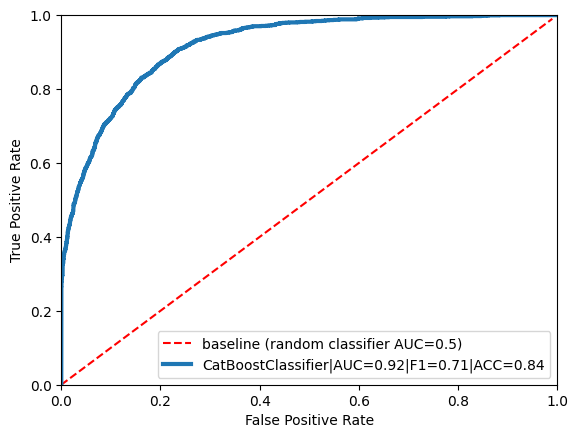

In [60]:
plot_roc_curve(model_catboost, X_test, y_test, '>50K')

In [61]:
y_pred= model_catboost.predict_proba(X_test)
x, y = calibration_curve(y_test, y_pred[:, 1], n_bins = 10, normalize = True, pos_label='>50K') 

/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


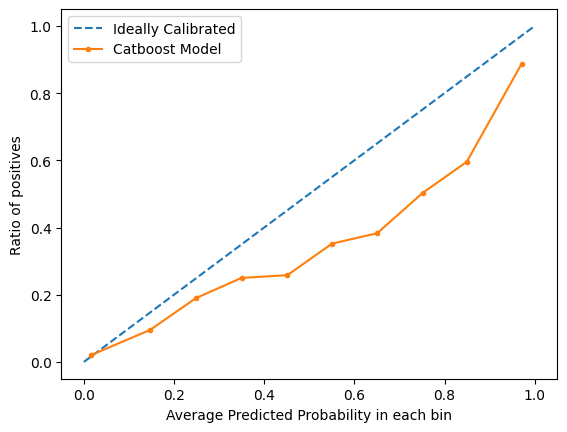

In [62]:
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')   
plt.plot(y, x, marker = '.', label = 'Catboost Model') 
plt.xlabel('Average Predicted Probability in each bin') 
plt.ylabel('Ratio of positives') 
plt.legend()
plt.show()

In [63]:
calibrated = CalibratedClassifierCV(model_catboost, cv='prefit', method='isotonic')
calibrated.fit(X_test, y_test)

CalibratedClassifierCV(cv='prefit',
                       estimator=<catboost.core.CatBoostClassifier object at 0x291ba6560>,
                       method='isotonic')

/Users/jniedziela/.pyenv/versions/3.10.0/envs/DM/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


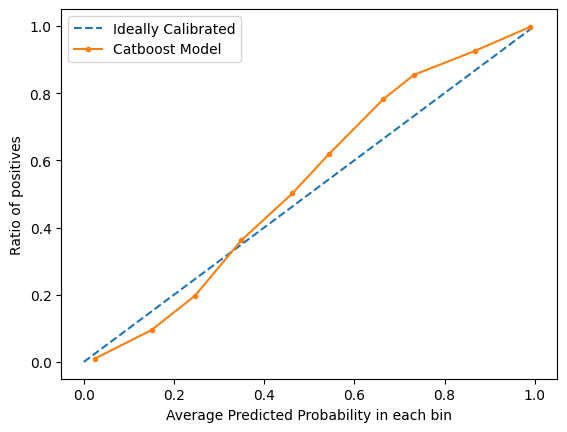

In [64]:
y_pred = calibrated.predict_proba(pd.concat([X_test, X_train]))
x, y = calibration_curve(pd.concat([y_test, y_train]), y_pred[:, 1], n_bins = 10, normalize = True, pos_label='>50K') 
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')   
plt.plot(y, x, marker = '.', label = 'Catboost Model') 
plt.xlabel('Average Predicted Probability in each bin') 
plt.ylabel('Ratio of positives') 
plt.legend()
plt.show() 

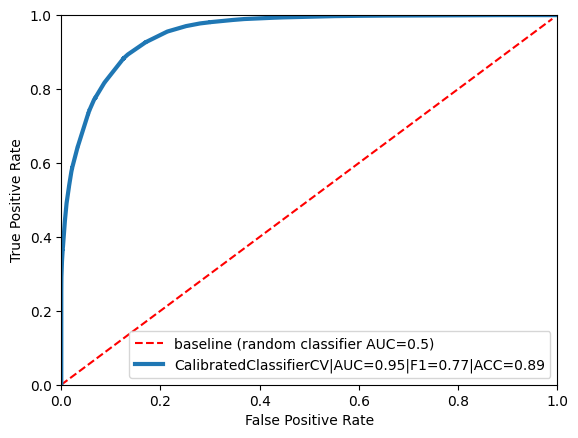

In [66]:
plot_roc_curve(calibrated, pd.concat([X_test, X_train]), pd.concat([y_test, y_train]), '>50K')

In [80]:
from joblib import dump

In [81]:
dump(calibrated, 'catboost_models/calibrated_v2.joblib')

['catboost_models/calibrated_v2.joblib']